## Customer Support Agent With Long & Short Term Memory

In [26]:
import os
from dotenv import load_dotenv

In [27]:
os.environ['LANGCHAIN_TRACING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = "langgraph_customer_support_agent_tutorial"

### Basic Imports

In [28]:
import uuid
from langgraph.store.memory import InMemoryStore

In [29]:
in_memory_store = InMemoryStore()

### Store Information in Long Term Memory

In [30]:
# Namespace for the memory to save
customer_id = "1"
namespace_for_memory = (customer_id, "customer_interactions")

# Save memory to namespace as key value pairs
key = "1"
values = {"name": "John Doe", "email": "rutvikjshah@gmail.com"}

# Save the memory to Disk
in_memory_store.put(namespace=namespace_for_memory, key=key, value=values)

### Search Memory

In [31]:
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [32]:
memories

[Item(namespace=['1', 'customer_interactions'], key='1', value={'name': 'John Doe', 'email': 'rutvikjshah@gmail.com'}, created_at='2025-02-26T16:54:06.189699+00:00', updated_at='2025-02-26T16:54:06.189700+00:00', score=None)]

In [33]:
memories[0].dict()

{'namespace': ['1', 'customer_interactions'],
 'key': '1',
 'value': {'name': 'John Doe', 'email': 'rutvikjshah@gmail.com'},
 'created_at': '2025-02-26T16:54:06.189699+00:00',
 'updated_at': '2025-02-26T16:54:06.189700+00:00',
 'score': None}

In [34]:
memories[0].value

{'name': 'John Doe', 'email': 'rutvikjshah@gmail.com'}

### Getting Memory Using Key And Namespace

In [35]:
memory = in_memory_store.get(namespace=namespace_for_memory, key=key)
memory.dict()

{'namespace': ['1', 'customer_interactions'],
 'key': '1',
 'value': {'name': 'John Doe', 'email': 'rutvikjshah@gmail.com'},
 'created_at': '2025-02-26T16:54:06.189699+00:00',
 'updated_at': '2025-02-26T16:54:06.189700+00:00'}

### Delete Memory

In [36]:
in_memory_store.delete(namespace=namespace_for_memory, key=key)

In [39]:
memory = in_memory_store.get(namespace=namespace_for_memory, key=key)

if memory:
    memory.dict()

### Creating Customer Support Agent with Long And Short Term Memory

### Creating Model

In [40]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")


In [41]:
COMPANY_NAME = "Code With Prince PLC"

MODEL_SYSTEM_MESSAGE = """You are a helpful customer support assistant for  {company_name}.
Use the customer's history to provide relevant and personalized support.
Customer profile: {history}"""

CREATE_HISTORY_INSTRUCTION = """Update the customer profile with new support interaction details.

CURRENT_PROFILE:
{history}

ANALYZE FOR:
1. Contact history
2. Product usage/purchase
3. Previous issues/resolutions
4. Preferences (communication, products)
5. Special circumstances

Focus on verified support interactions only. Summarize key details clearly.

Update profile based on this Conversation:"""

### Nodes

In [42]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

In [45]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Generates AI responses using customer context and history.
    Args:
        state: Current conversation messages
        config: Runtime configuration with customer_id
        store: Persistant storage for customer data

    Returns:
        dict: Generated response messages

    Flow:
        1. Gets customer profile from store using ID
        2. Formats system prompt with customer context
        3. Generates personalized response
    """

    customer_id = config["configurable"]["customer_id"]
    namespace = ("customer_interaction", customer_id)
    key = "customer_data_memory"
    memory = store.get(namespace, key)

    history = memory.value.get('customer_data_memory') if memory else "No existing memory found."

    system_msg = MODEL_SYSTEM_MESSAGE.format(history=history, company_name=COMPANY_NAME)
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}


In [46]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Updates customer interaction history in persistent storage.

    Args:
        state: Current conversation message
        config: Runtime config containing customer_id
        store: Persistent storage for customer data
    
    Flow:
        1. Retrieves existing customer history
        2. Analyzes conversation for new insights
        3.
    
    """

    user_id = config["configurable"]["customer_id"]
    namespace = ("customer_interactions", user_id)
    key = "customer_data_memory"
    memory = store.get(namespace=namespace, key=key)

    history = memory.value.get(key) if memory else "No existing history."

    system_message = CREATE_HISTORY_INSTRUCTION.format(history=history)
    new_insight = model.invoke([SystemMessage(content=system_message)] + state["messages"])
    store.put(namespace, key, {"customer_interactions": new_insight.content})
    

In [47]:
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()

graph = builder.compile(
    checkpointer = within_thread_memory,
    store = across_thread_memory
)

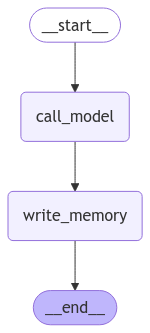

In [48]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))